# Image classification using CNNs in Keras 

The project is from a dataset from Kaggle. 
Link to the Kaggle project site: https://www.kaggle.com/c/plant-seedlings-classification/data 

Context: 
Can you differentiate a weed from a crop seedling?  
The ability to do so effectively can mean better crop yields and better stewardship of the environment.  
The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has 
recently released a dataset containing images of unique plants belonging to 12 species at several growth stages

Steps and tasks: 
1. Import the libraries, load dataset, print shape of data, visualize the images in dataset. (5 Marks) 
2. Data Pre-processing: (15 Marks) a. Normalization. b. Gaussian Blurring. c. Visualize data after pre-processing. 
3. Make data compatible: (10 Marks) a. Split the dataset into training, testing, and validation set.  (Hint: First split train images and train labels into training and testing set with test_size = 0.3. Then further split test data into test and validation set with test_size = 0.5) [Read the note at the end of the problem statement for the reason behind using the train images for using for training and testing set.] b. Reshape data into shapes compatible with Keras models. c. Convert labels from digits to one hot vectors. d. Print the label for y_train[0]. 
4. Building CNN: (15 Marks) 
    a. Define layers. 
    b. Set optimizer and loss function. (Use Adam optimizer and categorical crossentropy.) 
5. Fit and evaluate model and print confusion matrix. (10 Marks) 
6. Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]. (5 Marks) 
Note: Download the train images from the Kaggle dataset, don’t download the test images.  As the test dataset is not labeled, so you won’t be able to calculate the accuracy score. So use train images and train labels only to split further into training and testing set during your model building. 

In [0]:
#Import necessary libraries

import cv2
import math
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
%matplotlib inline
import os
import s3fs

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Loading & Visualization

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Set the path to the dataset folder. (The dataset contains image folder: "train")
train_path = r"/content/drive/My Drive/Colab Notebooks/train.zip"

In [0]:
# Make different folders for train and test data in the current directory of Google Colab notebook. (using mkdir)
!mkdir temp_train

In [0]:
!unzip -uq "/content/drive/My Drive/Colab Notebooks/train.zip" -d "/content/drive/My Drive/Colab Notebooks/temp_train"

In [0]:
path = r"/content/drive/My Drive/Colab Notebooks/temp_train/*/*.png"   # The path to all images in training set. (* means include all folders and files.)
files = glob(path)

trainImg = []                                              # Initialize empty list to store the image data as numbers.
trainLabel = []                                            # Initialize empty list to store the labels of images
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    '''
    Append the image data to trainImg list.
    Append the labels to trainLabel list.
    '''
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (128, 128)))  # Get image (with resizing to 128x128)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name contains the class to which the image belongs)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

In [0]:
print(trainImg.shape)
print(trainLabel.shape)

(4750, 128, 128, 3)
(4750, 1)


In [0]:
#save the path into variable to use it easily next time.
seed_train = r"/content/drive/My Drive/Colab Notebooks/temp_train"

In [0]:
images_per_class = {}
for class_folder_name in os.listdir(seed_train):
    class_folder_path = os.path.join(seed_train, class_folder_name)
    class_label = class_folder_name
    images_per_class[class_label] = []
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images_per_class[class_label].append(image_bgr)

In [0]:
#see number of images in each class

for key,value in images_per_class.items():
    print("{0} -> {1}".format(key, len(value)))

Cleavers -> 287
Scentless Mayweed -> 516
Common wheat -> 221
Fat Hen -> 475
Sugar beet -> 385
Maize -> 221
Common Chickweed -> 611
Small-flowered Cranesbill -> 496
Loose Silky-bent -> 654
Shepherds Purse -> 231
Black-grass -> 263
Charlock -> 390
train -> 0


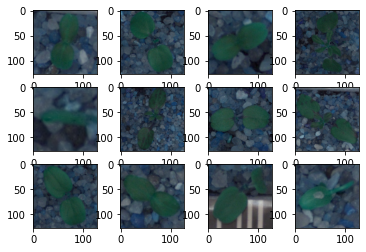

In [0]:
for i in range(12):
  plt.subplot(3,4, i+1)
  plt.imshow(trainImg[i])

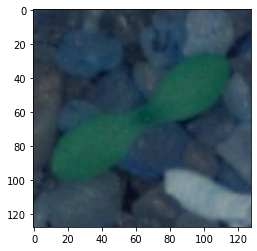

In [0]:
#image after resize 

plt.imshow(trainImg[666])

In [0]:
#train one image

img1 = cv2.imread("333")

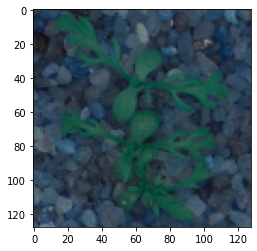

In [0]:
plt.imshow(trainImg[333])

# Data Pre-processing

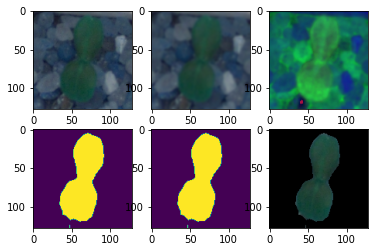

In [0]:
clearTrainImg = []
examples = []; getEx = True
for img in trainImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTrainImg = np.asarray(clearTrainImg)

In [0]:
clearTrainImg[0].shape

(128, 128, 3)

In [0]:
#Define contours for feature mapping

def find_contours(mask_image):
    return cv2.findContours(mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

def calculate_largest_contour_area(contours):
    if len(contours) == 0:
        return 0
    c = max(contours, key=cv2.contourArea)
    return cv2.contourArea(c)

def calculate_contours_area(contours, min_contour_area = 250):
    area = 0
    for c in contours:
        c_area = cv2.contourArea(c)
        if c_area >= min_contour_area:
            area += c_area
    return area

In [0]:
areas = []
larges_contour_areas = []
labels = []
nb_of_contours = []
images_height = []
images_width = []

for class_label in images_per_class.keys():
    for image in images_per_class[class_label]:
        mask = mask #create_mask_for_plant(image)
        contours = find_contours(mask)
        
        area = calculate_contours_area(contours)
        largest_area = calculate_largest_contour_area(contours)
        height, width, channels = image.shape
        
        images_height.append(height)
        images_width.append(width)
        areas.append(area)
        nb_of_contours.append(len(contours))
        larges_contour_areas.append(largest_area)
        labels.append(class_label)

In [0]:
features_df = pd.DataFrame()
features_df["label"] = labels
features_df["area"] = areas
features_df["largest_area"] = larges_contour_areas
features_df["number_of_components"] = nb_of_contours
features_df["height"] = images_height
features_df["width"] = images_width

In [0]:
features_df.groupby("label").describe()

area               ...  width                
                           count    mean  std  ...    50%     75%     max
label                                          ...                       
Black-grass                263.0  3717.0  0.0  ...  586.0  906.00  2840.0
Charlock                   390.0  3717.0  0.0  ...  375.5  514.75  1582.0
Cleavers                   287.0  3717.0  0.0  ...  298.0  423.00   866.0
Common Chickweed           611.0  3717.0  0.0  ...  156.0  376.50   718.0
Common wheat               221.0  3717.0  0.0  ...  456.0  651.00  1432.0
Fat Hen                    475.0  3717.0  0.0  ...  234.0  369.00  1273.0
Loose Silky-bent           654.0  3717.0  0.0  ...  197.0  535.75  3991.0
Maize                      221.0  3717.0  0.0  ...  415.0  706.00  1900.0
Scentless Mayweed          516.0  3717.0  0.0  ...  123.0  363.50  1227.0
Shepherds Purse            231.0  3717.0  0.0  ...  169.0  400.00  1317.0
Small-flowered Cranesbill  496.0  3717.0  0.0  ...  286.0  459.25  1006.0
Sugar beet                 385.0  3717.0  0.0  ...  551.0  744.00  1715.0

[12 rows x 40 columns]

# Make Data Compatible

In [0]:
#apply label encoding

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(trainLabel)

In [0]:
y[0]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
#split data in train and test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(trainImg, y, test_size=0.3, random_state=50)

In [0]:
X_train[0].shape

(128, 128, 3)

In [0]:
#create validation set

random_seed = 2
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, Y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [0]:
print(X_test[0].shape)
print(X_val[0].shape)

(128, 128, 3)
(128, 128, 3)


# Build CNN Model

In [0]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Set the CNN model 

batch_size = None

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', batch_input_shape = (batch_size,128, 128, 3)))


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))



model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(12, activation = "softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)       

In [0]:
#Optimize the model

opt = Adam(lr=0.001)

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [0]:
#Fit and run the model

model.fit(X_train, y_train, epochs = 30, validation_data = (X_val,Y_val),batch_size = batch_size)

Train on 3325 samples, validate on 713 samples
Epoch 1/30
3325/3325 [==============================] - 545s 164ms/step - loss: 2.8257 - accuracy: 0.1447 - val_loss: 2.3202 - val_accuracy: 0.2665
Epoch 2/30
3325/3325 [==============================] - 544s 164ms/step - loss: 2.1338 - accuracy: 0.2496 - val_loss: 2.0158 - val_accuracy: 0.2945
Epoch 3/30
3325/3325 [==============================] - 565s 170ms/step - loss: 1.9585 - accuracy: 0.3029 - val_loss: 1.9246 - val_accuracy: 0.3633
Epoch 4/30
3325/3325 [==============================] - 593s 178ms/step - loss: 1.7965 - accuracy: 0.3576 - val_loss: 1.7340 - val_accuracy: 0.4488
Epoch 5/30
3325/3325 [==============================] - 567s 171ms/step - loss: 1.7044 - accuracy: 0.3955 - val_loss: 1.6043 - val_accuracy: 0.4376
Epoch 6/30
3325/3325 [==============================] - 561s 169ms/step - loss: 1.5915 - accuracy: 0.4355 - val_loss: 1.7286 - val_accuracy: 0.4684
Epoch 7/30
3325/3325 [==============================] - 562s 169m

In [0]:
score = model.evaluate(X_test, y_test, verbose=0, batch_size = 38)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6822392102540209
Test accuracy: 0.75


In [0]:
X_test.shape

(712, 128, 128, 3)

# Refining the Model

In [0]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00025)
epochs = 10
batch_size = 76

In [0]:
#Data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [0]:
X_train, X_test, y_train, y_test
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/10
 - 545s - loss: 2.9573 - accuracy: 0.1333 - val_loss: 2.4554 - val_accuracy: 0.1290
Epoch 2/10
 - 542s - loss: 2.4508 - accuracy: 0.1317 - val_loss: 2.4416 - val_accuracy: 0.1346
Epoch 3/10
 - 543s - loss: 2.4483 - accuracy: 0.1462 - val_loss: 2.3180 - val_accuracy: 0.2342
Epoch 4/10
 - 546s - loss: 2.3685 - accuracy: 0.1971 - val_loss: 2.2637 - val_accuracy: 0.2707
Epoch 5/10
 - 542s - loss: 2.1986 - accuracy: 0.2557 - val_loss: 2.1595 - val_accuracy: 0.2945
Epoch 6/10
 - 551s - loss: 2.1517 - accuracy: 0.2723 - val_loss: 2.1865 - val_accuracy: 0.3240
Epoch 7/10
 - 546s - loss: 2.0485 - accuracy: 0.2938 - val_loss: 1.9764 - val_accuracy: 0.3787
Epoch 8/10
 - 552s - loss: 1.9408 - accuracy: 0.3463 - val_loss: 1.9896 - val_accuracy: 0.3156
Epoch 9/10
 - 555s - loss: 1.9159 - accuracy: 0.3421 - val_loss: 2.0791 - val_accuracy: 0.3394
Epoch 10/10
 - 547s - loss: 1.8414 - accuracy: 0.3808 - val_loss: 1.8798 - val_accuracy: 0.4208


In [0]:
score = model.evaluate(X_test, y_test, verbose=0, batch_size = None)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.848600844318947
Test accuracy: 0.4325842559337616


# Evaluate the Model

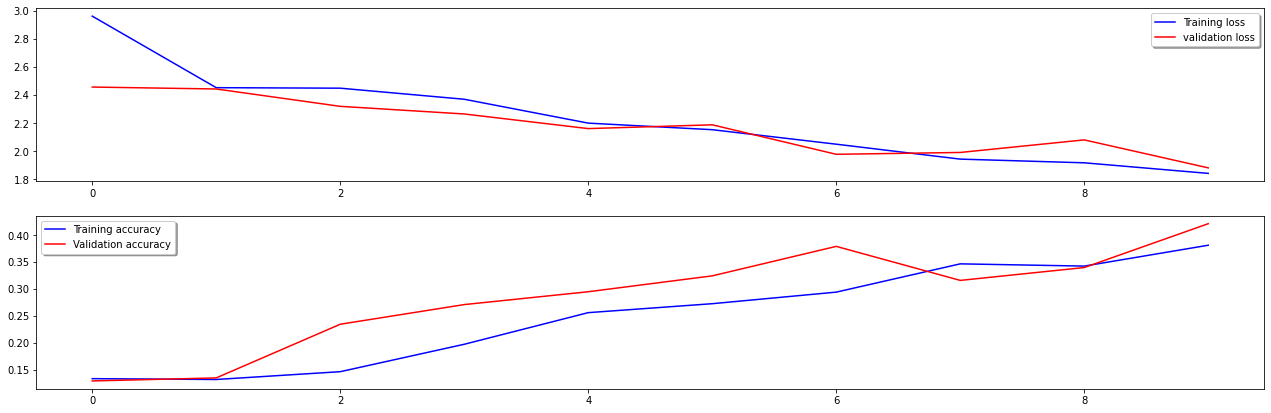

In [0]:
fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

KeyError: ignored

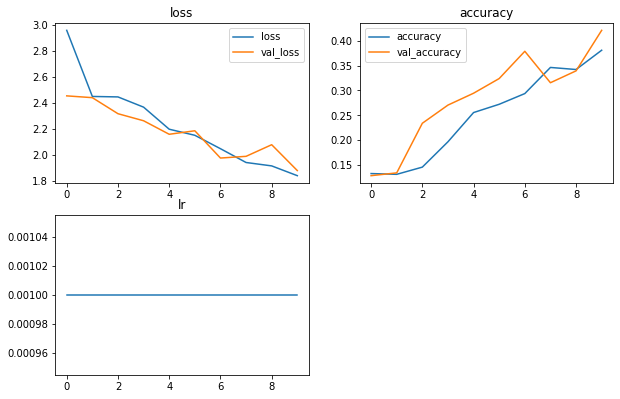

In [0]:
import matplotlib.pyplot as plt
def plot_model(model):
    plots = [i for i in model.history.history.keys() if i.find('val_') == -1]
    plt.figure(figsize=(10,10))

    for i, p in enumerate(plots):
        plt.subplot(len(plots), 2, i + 1)
        plt.title(p)
        plt.plot(model.history.history[p], label=p)
        plt.plot(model.history.history['val_'+p], label='val_'+p)
        plt.legend()

    plt.show()
    
plot_model(model)

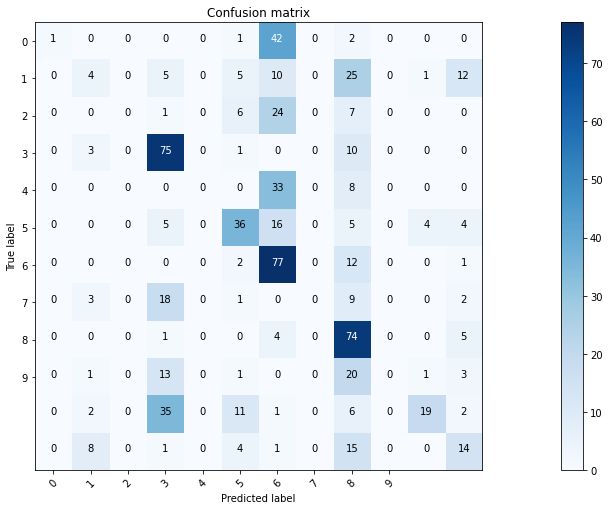

In [0]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

# Visualize Predictions

In [0]:
Predicted_classes = model.predict_classes(X_test)

In [0]:
wrong_preds = X_test[Predicted_classes != np.argmax(y_test)]

In [0]:
set(Predicted_classes)

{0, 1, 3, 5, 6, 8, 10, 11}

In [0]:
i = 10

Predicted class: Loose Silky-bent
Actual class: Charlock


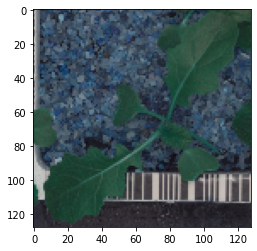

In [0]:
pred = model.predict_classes(np.array([wrong_preds[i]]))[0]
act = np.argmax(y_test[i])
print("Predicted class: {}".format(enc.classes_[pred]))
print("Actual class: {}".format(enc.classes_[act]))

plt.imshow(wrong_preds[i])

In [0]:
enc.inverse_transform(np.array([y_test[10]]))

array(['Charlock'], dtype='<U25')

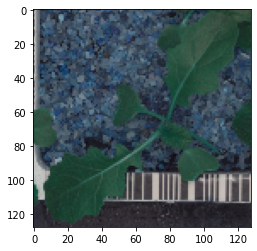

In [0]:
plt.imshow(X_test[10])

In [0]:
enc.classes_

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype='<U25')

In [0]:
#Echo November Delta